In [5]:
%cd C:\Users\esurujiu\AppData\Local\miniconda3\envs\GOs

import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL  
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from sklearn.decomposition import PCA
import pywt
import calendar
from statsmodels.graphics.tsaplots import month_plot
import scipy.stats as st
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import datetime

C:\Users\esurujiu\AppData\Local\miniconda3\envs\GOs


In [6]:
weekly = pd.read_csv('data/01_interim/GO_weekly_price_change.csv')

r = (weekly['return_cleaned'] * 100).dropna()        # % returns

def describe_returns(r):
    r = r.dropna()
    stats = {
        'obs'     : len(r),
        'mean'    : r.mean(),
        'std'     : r.std(),
        'skew'    : r.skew(),
        'kurt'    : r.kurtosis(),
        'min'     : r.min(),
        'max'     : r.max(),
        'VaR_95'  : r.quantile(0.05),
        'ES_95'   : r[r <= r.quantile(0.05)].mean()
    }
    return pd.Series(stats, name='Hydro spot returns')

summary = describe_returns(r)  # scale to %
print(summary.round(3))

jb_p   = st.jarque_bera(r).pvalue
print(f"Jarque-Bera p = {jb_p:.4e}")

obs       284.000
mean       -1.067
std        10.395
skew       -0.060
kurt        1.648
min       -38.972
max        32.208
VaR_95    -19.512
ES_95     -25.653
Name: Hydro spot returns, dtype: float64
Jarque-Bera p = 2.5174e-07


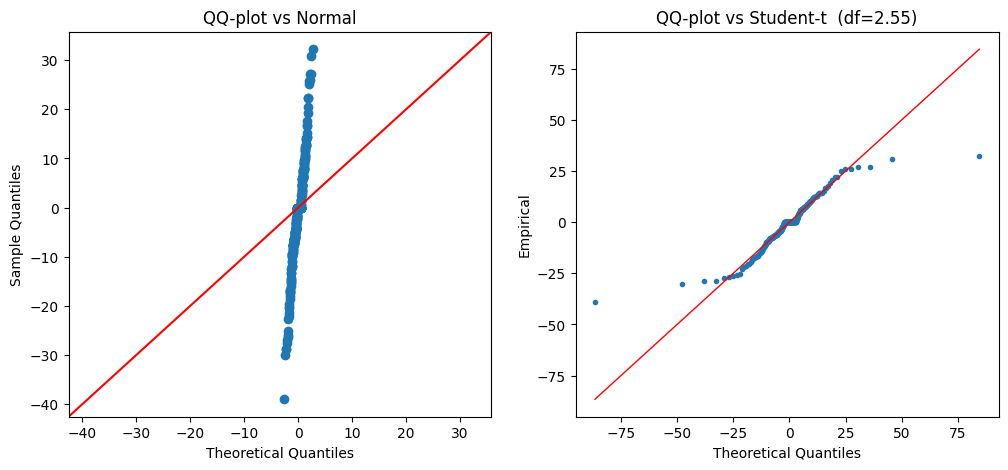

In [7]:
df_t, loc_t, scale_t = st.t.fit(r)

fig, axes = plt.subplots(1, 2, figsize=(12,5))

sm.qqplot(r, line='45', ax=axes[0])
axes[0].set_title('QQ-plot vs Normal')

q_theor = st.t.ppf(np.linspace(0.001, 0.999, len(r)), df_t, loc_t, scale_t)
q_emp = np.sort(r.values)

axes[1].plot(q_theor, q_emp, marker='o', linestyle='', ms=3)
axes[1].plot(q_theor, q_theor, color='r', lw=1)
axes[1].set_title(f'QQ-plot vs Student-t  (df={df_t:.2f})')
axes[1].set_xlabel('Theoretical Quantiles'); axes[1].set_ylabel('Empirical')

plt.show()

Gaussian μ=-1.067, σ=10.377
Student-t ν=2.68, scale=6.625


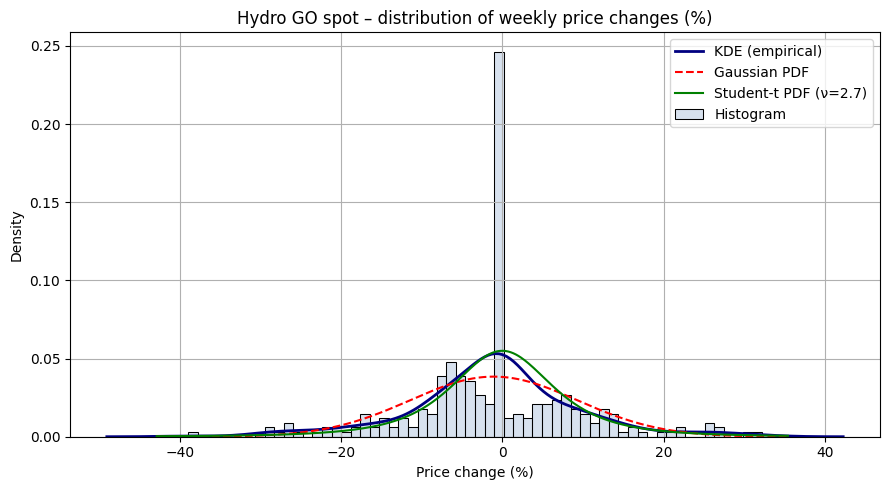

In [8]:
mu,  std  = st.norm.fit(r)            # Gaussian
df_t, loc_t, scale_t = st.t.fit(r, floc=0)  # Student-t, mean fixed at 0

print(f"Gaussian μ={mu:.3f}, σ={std:.3f}")
print(f"Student-t ν={df_t:.2f}, scale={scale_t:.3f}")

fig, ax = plt.subplots(figsize=(9,5))

# histogram
sns.histplot(r, bins=60, stat='density', color='lightsteelblue',
             edgecolor='k', alpha=0.5, ax=ax, label='Histogram')

# KDE (empirical smooth curve)
sns.kdeplot(r, color='navy', lw=2, ax=ax, label='KDE (empirical)')

# overlay Gaussian PDF
x = np.linspace(r.min()*1.1, r.max()*1.1, 500)
ax.plot(x, st.norm.pdf(x, mu, std), 'r--', lw=1.5, label='Gaussian PDF')

# overlay Student-t PDF
ax.plot(x, st.t.pdf(x, df_t, loc_t, scale_t), 'g-', lw=1.5,
        label=f'Student-t PDF (ν={df_t:.1f})')

# cosmetics
ax.set_title('Hydro GO spot – distribution of weekly price changes (%)')
ax.set_xlabel('Price change (%)'); ax.set_ylabel('Density')
ax.legend(); ax.grid(True); plt.tight_layout(); plt.show()